Import necessary packages.

In [1]:
import sys
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
import keras

Using TensorFlow backend.


Load data or images of MNIST images dataset.

In [2]:
# Load train
digits_train = np.genfromtxt(open('binMNIST_data/bindigit_trn.csv', "r"), delimiter=',')
targets_train = np.genfromtxt(open('binMNIST_data/targetdigit_trn.csv', "r"), delimiter=',')

# Load test data
digits_test = np.genfromtxt(open('binMNIST_data/bindigit_tst.csv', "r"), delimiter=',')
targets_test = np.genfromtxt(open('binMNIST_data/targetdigit_tst.csv', "r"), delimiter=',')

# Split train into training and validation set
def train_test_split(inputs, labels, fraction_train=0.8, seed=0):
    n = inputs.shape[0]
    n_train = int(fraction_train*n)
    np.random.seed(seed)
    indexes = np.random.permutation(n)
    indexes_train, indexes_test = indexes[:n_train], indexes[n_train:]
    digits_train_split, targets_train_split = inputs[indexes_train,:], labels[indexes_train]
    digits_test_split, targets_test_split = inputs[indexes_test,:], labels[indexes_test]
    
    return digits_train_split, targets_train_split, digits_test_split, targets_test_split

digits_train_split, targets_train_split, digits_val_split, targets_val_split = \
    train_test_split(digits_train, targets_train)

Find a sample for each digit.

In [3]:
demo_indices_train_split = []
demo_indices_val_split = []
for n in range(10):
    demo_indices_train_split.append(np.where(targets_train_split==n)[0][0])
    demo_indices_val_split.append(np.where(targets_val_split==n)[0][0])

Study distributions of digits.

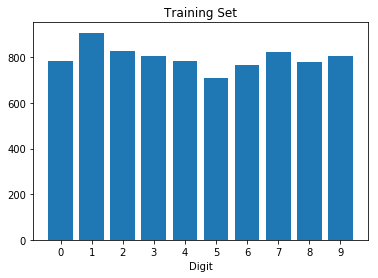

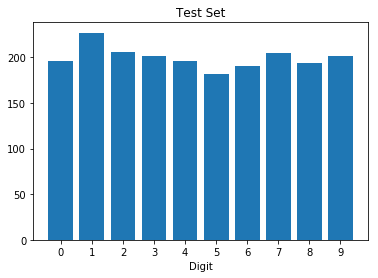

In [4]:
def digit_occurrences(targets, title="Training Set"):
    plt.figure()
    plt.bar(np.unique(targets), [sum(targets==x) for x in np.unique(targets)])
    plt.xticks(np.unique(targets))
    plt.xlabel("Digit")
    plt.title(title)

digit_occurrences(targets_train)
digit_occurrences(targets_test, title="Test Set")

Preview some images.

<Figure size 432x288 with 0 Axes>

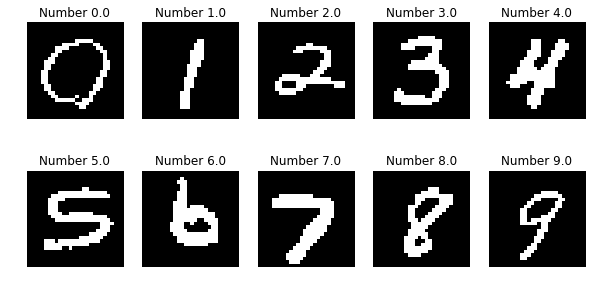

In [5]:
fig = plt.figure()
_, axes = plt.subplots(2, 5, figsize=(10,5))

for index, ax in zip(demo_indices_train_split, axes.flatten()):
    ax.imshow(digits_train_split[index,:].reshape(28, 28), cmap='gray')
    ax.set_title("Number "+str(targets_train_split[index]))
    ax.axis('off')

## 3.1. Autoencoder for binary-type MNIST images

Create a class to build and train an autoencoder with Keras.

In [6]:
class Autoencoder:
    
    def __init__(self,
                 hidden_nodes,
                 weight_initializer='RandomNormal',
                 biases_initializer='zeros',
                 activation_hidden='sigmoid',
                 learning_rate=0.01,
                 momentum=0.9,
                 batch_size=64,
                 regularization=0,
                 regularization_method='l1',
                 optimizer='adam',
                 loss='binary_crossentropy'
                ):

        self._hidden_nodes = hidden_nodes
        self._weight_initializer = weight_initializer
        self._biases_initializer = biases_initializer
        self._activation_hidden = activation_hidden
        self._learning_rate = learning_rate
        self._momentum = momentum
        self._batch_size = batch_size
        self._regularization = regularization
        self._regularization_method = regularization_method
        self._optimizer = optimizer
        self._loss = loss
    
    def _init_model(self, inputs, outputs):
        
        # Construct the network architecture
        reg_method = {
            'l1': keras.regularizers.l1,
            'l2': keras.regularizers.l2
        }[self._regularization_method]
        hidden_layer = keras.layers.Dense(
            units=self._hidden_nodes,
            input_shape=(inputs.shape[1],),
            activation=self._activation_hidden,
            kernel_initializer=self._weight_initializer,
            bias_initializer=self._biases_initializer,
            kernel_regularizer=reg_method(self._regularization),
        )       
        output_layer = keras.layers.Dense(
            units=outputs.shape[1],
            activation='sigmoid',
            kernel_initializer=self._weight_initializer,
            bias_initializer=self._biases_initializer,
            kernel_regularizer=reg_method(self._regularization)
        )
        self._model = keras.models.Sequential([hidden_layer, output_layer])

        # Set up optimization
        opt = {
            'SGD': keras.optimizers.SGD,
            'SGD_momentum': partial(keras.optimizers.SGD, momentum=self._momentum),
            'SGD_momentum_nesterov': partial(keras.optimizers.SGD, momentum=self._momentum, nesterov=True),
            'Adagrad': keras.optimizers.Adagrad,
            'Adadelta': keras.optimizers.Adadelta,
            'RMSprop': keras.optimizers.RMSprop,
            'Adam': keras.optimizers.Adam,
            'Adamax': keras.optimizers.Adamax,
            'Nadam': keras.optimizers.Nadam,
            'Adam_amsgrad': partial(keras.optimizers.Adam, amsgrad=True)
        }[self._optimizer]
        if self._learning_rate is not None:
            opt = opt(lr=self._learning_rate)
        else:
            opt = opt()
        self._model.compile(optimizer=opt, loss=self._loss, metrics=['mae'])
    
    def train(self,
              inputs,
              outputs=None,
              inputs_val=None,
              outputs_val=None,
              epochs=1,
              noise=None,
              early_stopping=False,
              early_stopping_min_delta=None,
              early_stopping_patience=None,
              early_stopping_verbose=0,
              learning_curve=False
             ):
        
        # Define training outputs in autoencoder case (no outputs given)
        if outputs is None:
            outputs = inputs
        
        # Add noise to data (if required)
        if noise is not None:
            inputs = inputs+noise*np.random.rand(*inputs.shape)
        
        # Initialize model
        self._init_model(inputs, outputs)
        
        # Set up validation set (if required)
        if inputs_val is not None and outputs_val is None:
            outputs_val = inputs_val
            validation_data = (inputs_val, outputs_val)
        elif inputs_val is not None:
            validation_data = (inputs_val, outputs_val)
        else:
            validation_data = None

        # Define convergence criterion
        if not early_stopping:
            self._callbacks = []
        else:
            self._callbacks = [keras.callbacks.EarlyStopping(monitor='loss',
                                                             min_delta=early_stopping_min_delta,
                                                             patience=early_stopping_patience,
                                                             verbose=early_stopping_verbose)]

        # Train model
        history = self._model.fit(inputs,
                                  outputs,
                                  validation_data=validation_data,
                                  batch_size=self._batch_size,
                                  epochs=epochs,
                                  callbacks=self._callbacks,
                                  verbose=0)

        # Store errors for learning curve
        if learning_curve:
            errors = {'epochs': range(1, epochs+1),
                      'loss_train': history.history['loss'],
                      'mean_absolute_error_train': history.history['mean_absolute_error']}
            if inputs_val is not None:
                errors['loss_val'] = history.history['val_loss']
                errors['mean_absolute_error_val'] = history.history['val_mean_absolute_error']
            
            return errors

    def predict(self, new_inputs):
        return self._model.predict(new_inputs)

### Find optimal parametrization

In [7]:
def plot_learning_curve(errors, metric='loss', label='', title=''):
    plt.plot(errors['epochs'], errors[metric+'_train'], label=str(label)+' (Train Set)')
    if len(errors)>3:
        plt.plot(errors['epochs'], errors[metric+'_val'], label=str(label)+' (Val Set)', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.title("Learning curve by "+str(title))
    
def compare_learning_curve(parameter_to_compare, values_to_compare, labels_values_to_compare=None,
                           arguments_to_compare_in='model_arguments',
                           metric='loss',
                           model_arguments={'hidden_nodes':784},
                           train_arguments={'inputs':digits_train_split,
                                            'epochs':20,
                                            'learning_curve':True}):

    plt.figure(figsize=(15,5))
    if labels_values_to_compare is None:
        labels_values_to_compare = values_to_compare
    
    # Train with each value to compare and plot learning curve
    models = {}
    for value, label in zip(values_to_compare, labels_values_to_compare):
        
        # Edit the arguments specifying the value of the parameter to compare
        print("Training: "+parameter_to_compare+' '+str(value))
        if arguments_to_compare_in=='model_arguments':
            model_arguments[parameter_to_compare] = value
        elif arguments_to_compare_in=='train_arguments':
            train_arguments[parameter_to_compare] = value
        
        # Build the model
        model = Autoencoder(**model_arguments)
        
        # Train the model
        errors = model.train(**train_arguments)
        
        # Plot the learning curve and save the model
        plot_learning_curve(errors, metric, label=value, title=parameter_to_compare)
        models[value] = model
    
    return models

- Find suitable optimizer.

Training: optimizer SGD
Training: optimizer SGD_momentum
Training: optimizer SGD_momentum_nesterov
Training: optimizer Adagrad
Training: optimizer Adadelta
Training: optimizer RMSprop
Training: optimizer Adam
Training: optimizer Adamax
Training: optimizer Nadam
Training: optimizer Adam_amsgrad


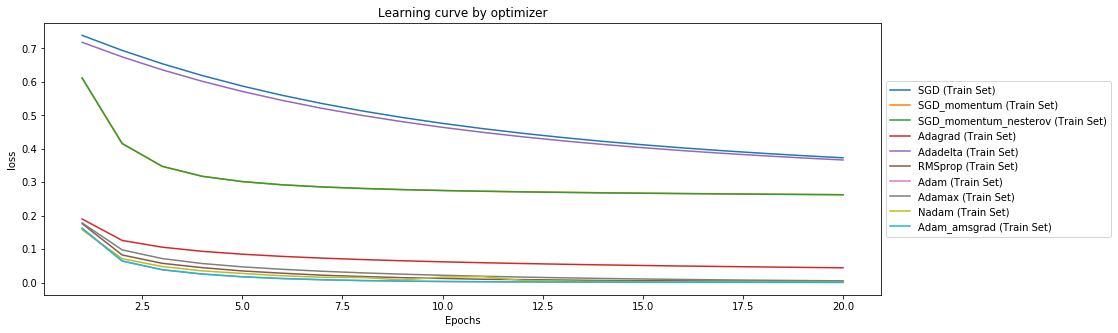

In [8]:
parameter_to_compare = 'optimizer'
values_to_compare = ['SGD','SGD_momentum','SGD_momentum_nesterov','Adagrad','Adadelta','RMSprop','Adam',
                     'Adamax','Nadam','Adam_amsgrad']
compare_learning_curve(parameter_to_compare, values_to_compare)

- Find suitable learning rate.

Training: learning_rate 0.001
Training: learning_rate 0.005
Training: learning_rate 0.01
Training: learning_rate 0.05


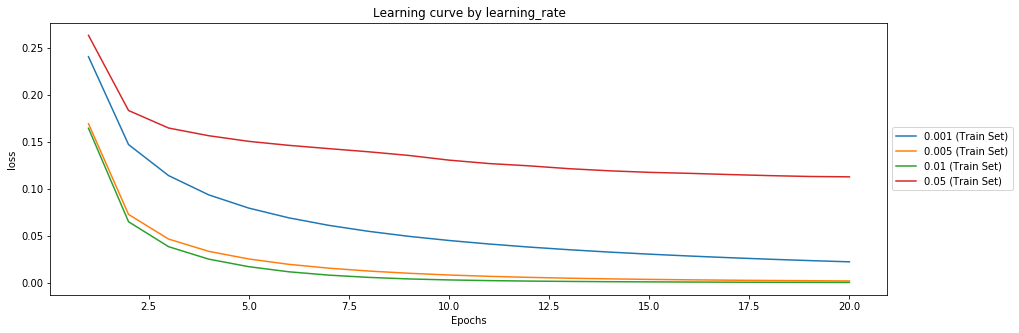

In [9]:
parameter_to_compare = 'learning_rate'
values_to_compare = [0.001,0.005,0.01,0.05]
compare_learning_curve(parameter_to_compare, values_to_compare,
                       model_arguments={'hidden_nodes': 784,
                                        'optimizer': 'Adam_amsgrad'})

- Find suitable bach size.

Training: batch_size 8
Training: batch_size 16
Training: batch_size 32
Training: batch_size 62
Training: batch_size 124


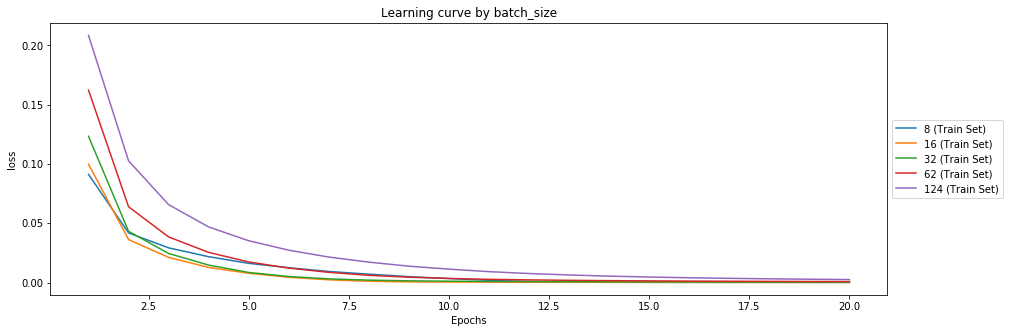

In [10]:
parameter_to_compare = 'batch_size'
values_to_compare = [8,16,32,62,124]
compare_learning_curve(parameter_to_compare, values_to_compare,
                       model_arguments={'hidden_nodes': 784,
                                        'optimizer': 'Adam_amsgrad',
                                        'learning_rate': 0.01})

### Undercomplete representations without noise: 100, 200, 400 hidden nodes

Compare learning curves by hidden nodes.

Training: hidden_nodes 100
Training: hidden_nodes 200
Training: hidden_nodes 400


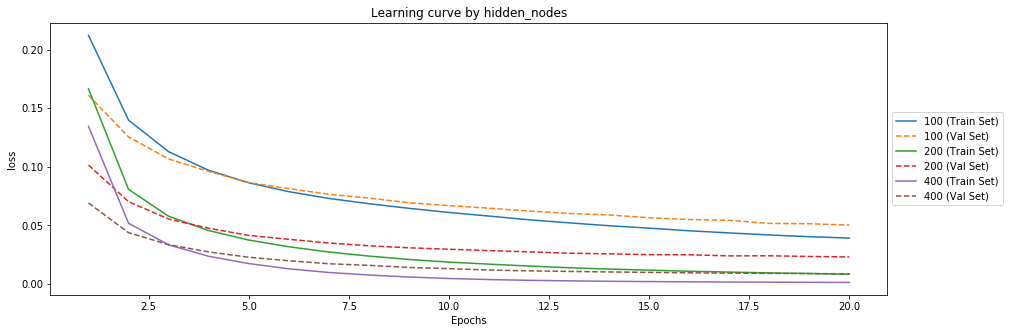

In [11]:
parameter_to_compare = 'hidden_nodes'
values_to_compare = [100,200,400]
saved_models_by_hidden_nodes = compare_learning_curve(parameter_to_compare,values_to_compare,
                                                      model_arguments={'optimizer': 'Adam_amsgrad',
                                                                       'learning_rate': 0.01,
                                                                       'batch_size': 32},
                                                      train_arguments={'inputs': digits_train_split,
                                                                       'inputs_val': digits_val_split,
                                                                       'epochs': 20,
                                                                       'learning_curve': True})

Compare predictions by hidden nodes.

In [12]:
def preview_predictions_autoencoder(model, inputs_to_preview, title='', noise=0):
    cols = 3 if noise==0 else 4
    fig, ax = plt.subplots(inputs_to_preview.shape[0], cols, figsize=[10,inputs_to_preview.shape[0]*2])
    
    # Iterate each image or input to preview
    for i, input_to_preview in enumerate(inputs_to_preview):
        
        # Plot original input
        ax[i][0].imshow(input_to_preview.reshape(28, 28))
        ax[i][0].axis('off')
        
        # Plot noisy input
        if noise!=0:
            np.random.seed(0)
            input_to_preview = input_to_preview+noise*np.random.rand(*input_to_preview.shape)
            ax[i][1].imshow(input_to_preview.reshape(28, 28))
            ax[i][1].axis('off')
        
        # Plot raw prediction
        predictions = model.predict(input_to_preview.reshape((1,784)))
        ax[i][1 if cols==3 else 2].imshow(predictions.reshape(28, 28))
        ax[i][1 if cols==3 else 2].axis('off')
        
        # Plot thresholded predictions: 1 if >=0.5 else 0
        predictions_threshold = predictions.copy()
        predictions_threshold[predictions_threshold<0.5] = 0
        predictions_threshold[predictions_threshold>=0.5] = 1
        ax[i][2 if cols==3 else 3].imshow(predictions_threshold.reshape(28, 28))
        ax[i][2 if cols==3 else 3].axis('off')
    
    if cols==3:
        plt.suptitle(title+": Original - Prediction - Thresholded Prediction")
    else:
        plt.suptitle(title+": Original - Noisy - Prediction - Thresholded Prediction") 

- 100 hidden nodes

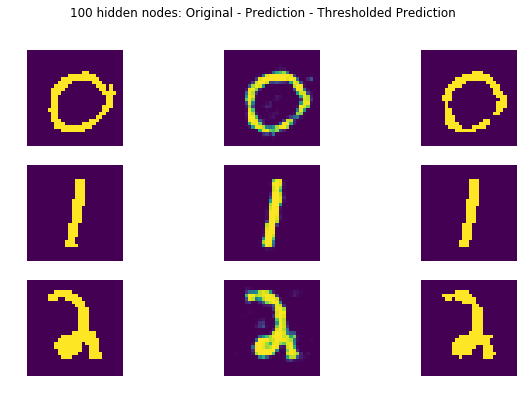

In [13]:
hidden_nodes = 100
inputs_to_preview = digits_val_split[demo_indices_val_split[0:3],:]
preview_predictions_autoencoder(saved_models_by_hidden_nodes[hidden_nodes],
                                inputs_to_preview,
                                title=str(hidden_nodes)+" hidden nodes")

- 400 hidden nodes

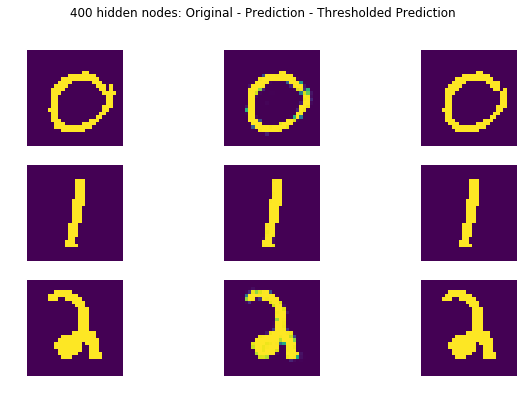

In [14]:
hidden_nodes = 400
inputs_to_preview = digits_val_split[demo_indices_val_split[0:3],:]
preview_predictions_autoencoder(saved_models_by_hidden_nodes[hidden_nodes],
                                inputs_to_preview,
                                title=str(hidden_nodes)+" hidden nodes")

Compare activations by hidden nodes. *Note*: the hidden layer corresponds to layer index 0, and the output layer to 1.

In [40]:
def visualize_activations_by_layer(model, layer_index, inputs_to_preview, title=''):
    
    # Get the hidden activation of the layer index required
    get_hidden_activations = keras.backend.function([model._model.layers[0].input],
                                                    [model._model.layers[layer_index].output])
    activations = get_hidden_activations([inputs_to_preview])[0]
    
    # Iterate the images or inputs to preview and plot their activations
    fig, axes = plt.subplots(int(inputs_to_preview.shape[0]/5), 5, figsize=[10,5])
    plt.suptitle("Activations of layer index "+str(layer_index)+title)
    for i, (activation,ax) in enumerate(zip(activations, axes.flatten())):
        dim = int(activation.shape[0]**0.5)
        ax.imshow(activation.reshape(dim, dim))
        ax.axis('off')
        ax.set_title("Digit "+str(i))

- 100 hidden nodes

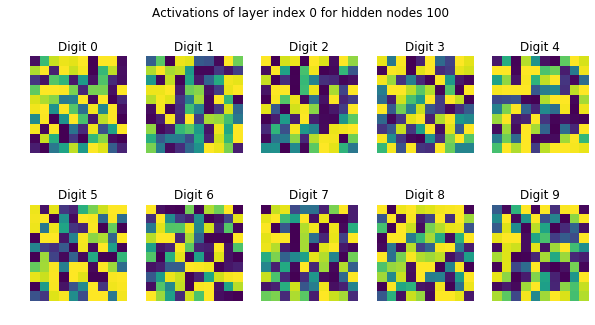

In [41]:
layer_index = 0
hidden_nodes = 100
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
visualize_activations_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                               layer_index,
                               inputs_to_preview,
                               title=" for hidden nodes "+str(hidden_nodes))

- 400 hidden nodes

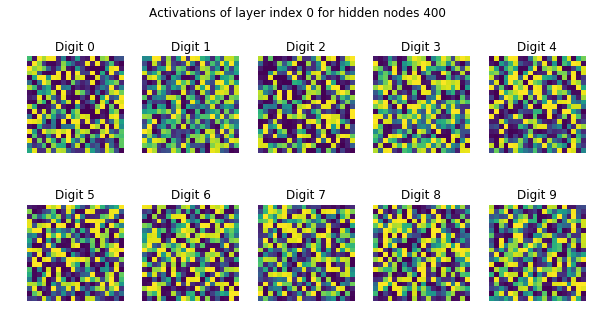

In [42]:
layer_index = 0
hidden_nodes = 400
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
visualize_activations_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                               layer_index,
                               inputs_to_preview,
                               title=" for hidden nodes "+str(hidden_nodes))

Compare sparsity of activations by hidden nodes.

In [44]:
def sparsity_activations_by_layer(model, layer_index, inputs_to_preview, threshold=0.5, title=''):
    
    # Get the hidden activation of the layer index required
    get_hidden_activations = keras.backend.function([model._model.layers[0].input],
                                                    [model._model.layers[layer_index].output])
    activations = get_hidden_activations([inputs_to_preview])[0]
    
    # Plot the histogram of the layer required activations
    fig = plt.figure(figsize=(5,5))
    plt.hist(activations.flatten(), bins=50) # .flatten() converts all inputs activations into one vector
    plt.axvline(threshold, color='r', linestyle='--')  
    plt.xlabel("Activation value")
    plt.ylabel("Frequency")
    plt.title("Sparsity for "+title)

- 100 hidden nodes

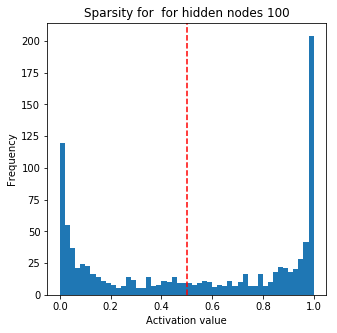

In [45]:
layer_index = 0
hidden_nodes = 100
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                              layer_index,
                              inputs_to_preview,
                              title=" for hidden nodes "+str(hidden_nodes))

- 400 hidden nodes

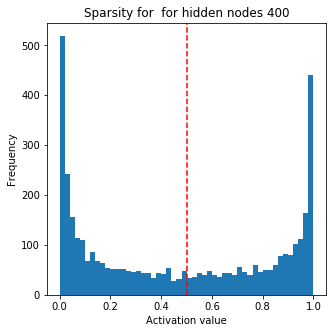

In [46]:
layer_index = 0
hidden_nodes = 400
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                              layer_index,
                              inputs_to_preview,
                              title=" for hidden nodes "+str(hidden_nodes))

Compare weights by hidden nodes.

In [49]:
def preview_weights_by_layer(model, layer_index, title='', limit_nodes=None):
    
    # Get the weights of the layer
    weights = model._model.layers[layer_index].get_weights()[0]
    weights = weights.T # tranpose to get rows = hidden nodes and cols = input nodes
    
    # Plot the weights of each node in the layer required, that connect to the previous layer
    if limit_nodes is None:
        limit_nodes = weights.shape[0]
    cols = 10
    rows = limit_nodes//cols
    fig, axes = plt.subplots(rows, cols, figsize=[2.5*cols,2.5*rows])
    plt.suptitle("Weights of layer "+str(layer_index)+title)
    for i, (w,ax) in enumerate(zip(weights, axes.flatten())):
        dim = int(w.shape[0]**0.5)
        ax.imshow(w.reshape(dim, dim), vmin=weights.min(), vmax=weights.max())
        ax.axis('off')
        ax.set_title("Node "+str(i+1))

- 100 hidden nodes

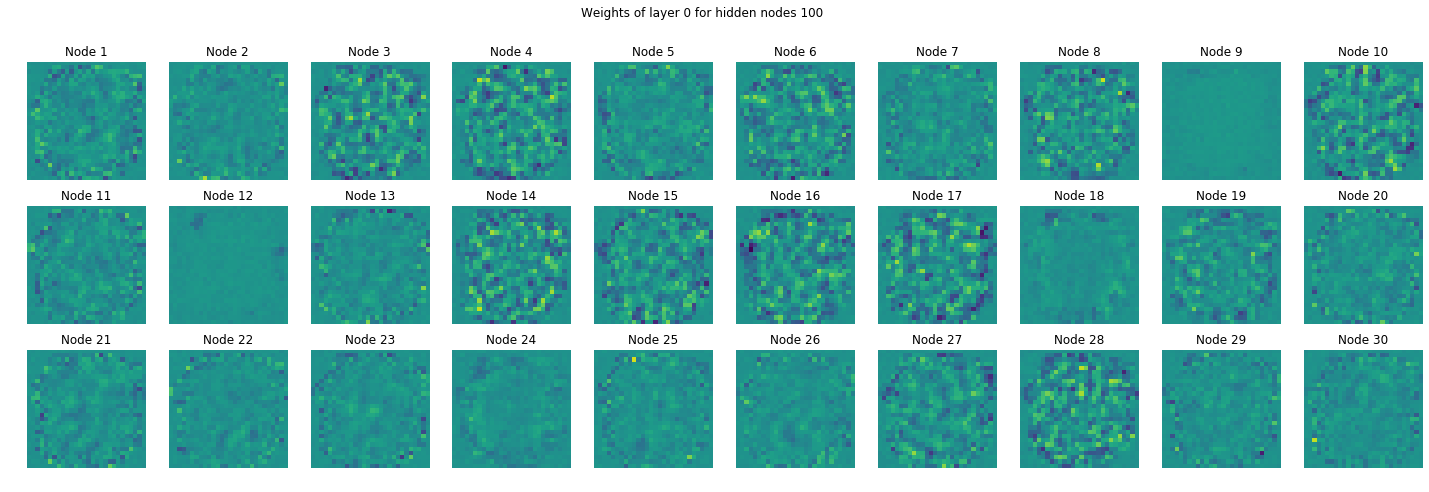

In [51]:
layer_index = 0
hidden_nodes = 100
preview_weights_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                         layer_index,
                         limit_nodes=30,
                         title=" for hidden nodes "+str(hidden_nodes))

- 400 hidden nodes

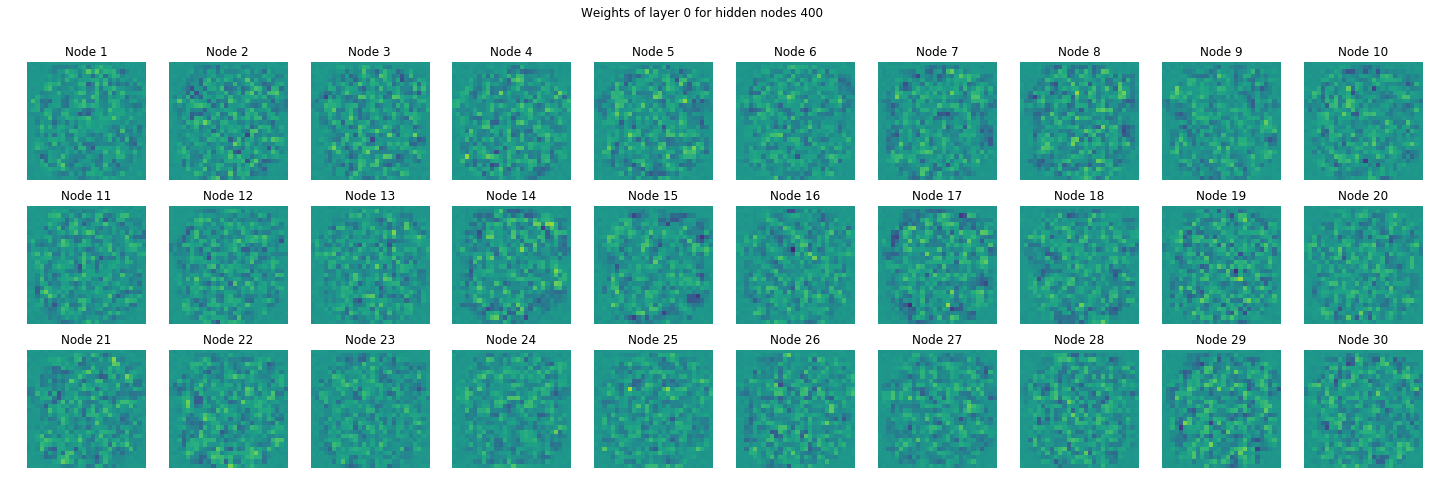

In [52]:
layer_index = 0
hidden_nodes = 400
preview_weights_by_layer(saved_models_by_hidden_nodes[hidden_nodes],
                         layer_index,
                         limit_nodes=30,
                         title=" for hidden nodes "+str(hidden_nodes))

### Undercomplete representations with noise: 400 hidden nodes

Compare lerning curves by noise.

Training: noise 0.0
Training: noise 0.2
Training: noise 0.4


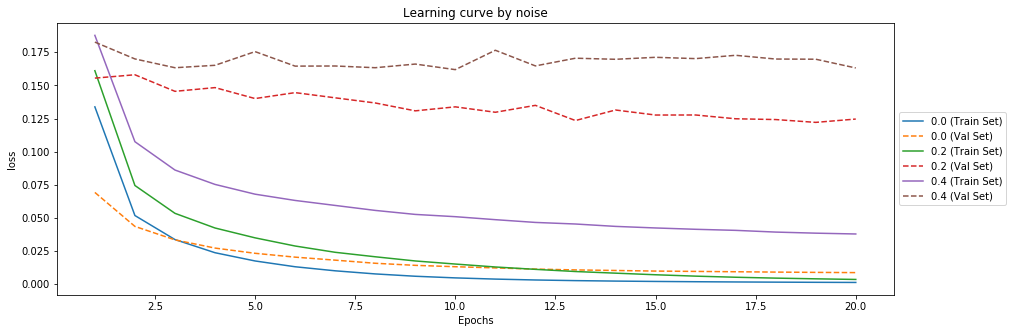

In [53]:
hidden_nodes = 400
parameter_to_compare = 'noise'
values_to_compare = [0.0,0.2,0.4]
saved_models_by_noise = compare_learning_curve(parameter_to_compare, values_to_compare,
                                               arguments_to_compare_in='train_arguments',
                                               model_arguments={'hidden_nodes': hidden_nodes,
                                                                'optimizer': 'Adam_amsgrad',
                                                                'learning_rate': 0.01,
                                                                'batch_size': 32},
                                               train_arguments={'inputs': digits_train_split,
                                                                'inputs_val': digits_val_split,
                                                                'epochs': 20,
                                                                'learning_curve': True})

Compare predictions adding noise to the inputs to predict by models trained with different noise levels added to the training data.

- 0 noise added to the training

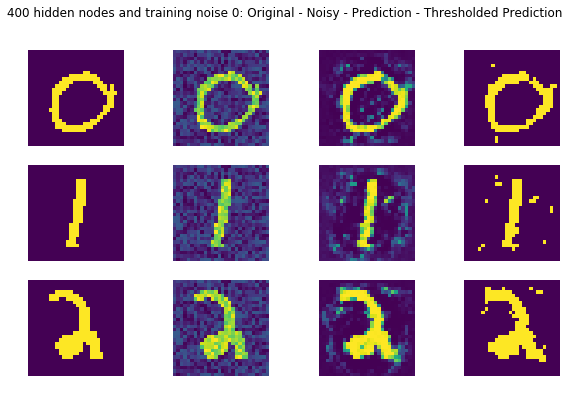

In [56]:
training_noise = 0
inputs_to_preview = digits_val_split[demo_indices_val_split[0:3],:]
preview_predictions_autoencoder(saved_models_by_noise[training_noise],
                                inputs_to_preview,
                                noise=0.4,
                                title=str(hidden_nodes)+" hidden nodes and training noise "+str(training_noise))

- 0.4 noise added to the training

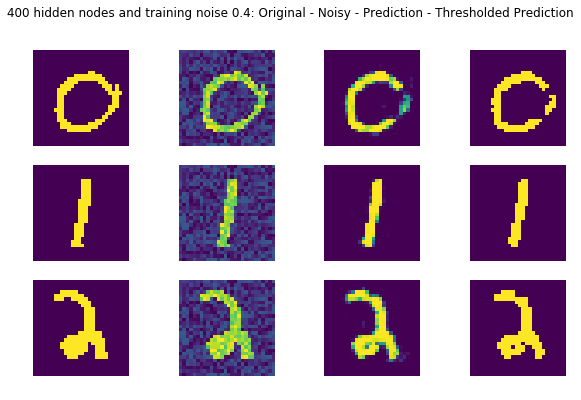

In [57]:
training_noise = 0.4
inputs_to_preview = digits_val_split[demo_indices_val_split[0:3],:]
preview_predictions_autoencoder(saved_models_by_noise[training_noise],
                                inputs_to_preview,
                                noise=0.4,
                                title= str(hidden_nodes)+" hidden nodes and training noise "+ \
                                       str(training_noise))

Compare sparsity of activations by noise.

- 0 noise added to the training

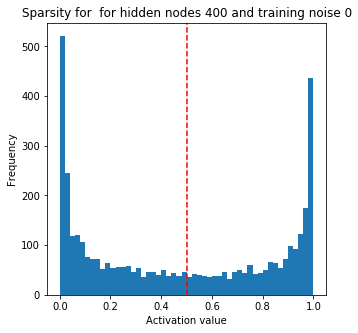

In [58]:
layer_index = 0
training_noise = 0
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_noise[training_noise],
                              layer_index,
                              inputs_to_preview,
                              title=" for hidden nodes "+str(hidden_nodes)+" and training noise "+ \
                                    str(training_noise))

- 0.4 noise added to the training

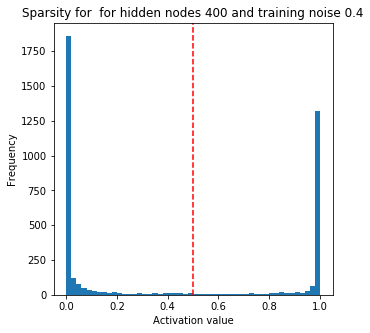

In [59]:
layer_index = 0
training_noise = 0.4
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_noise[training_noise],
                              layer_index,
                              inputs_to_preview,
                              title=" for hidden nodes "+str(hidden_nodes)+" and training noise "+ \
                                    str(training_noise))

Compare weights by noise.

- 0 noise added to the training

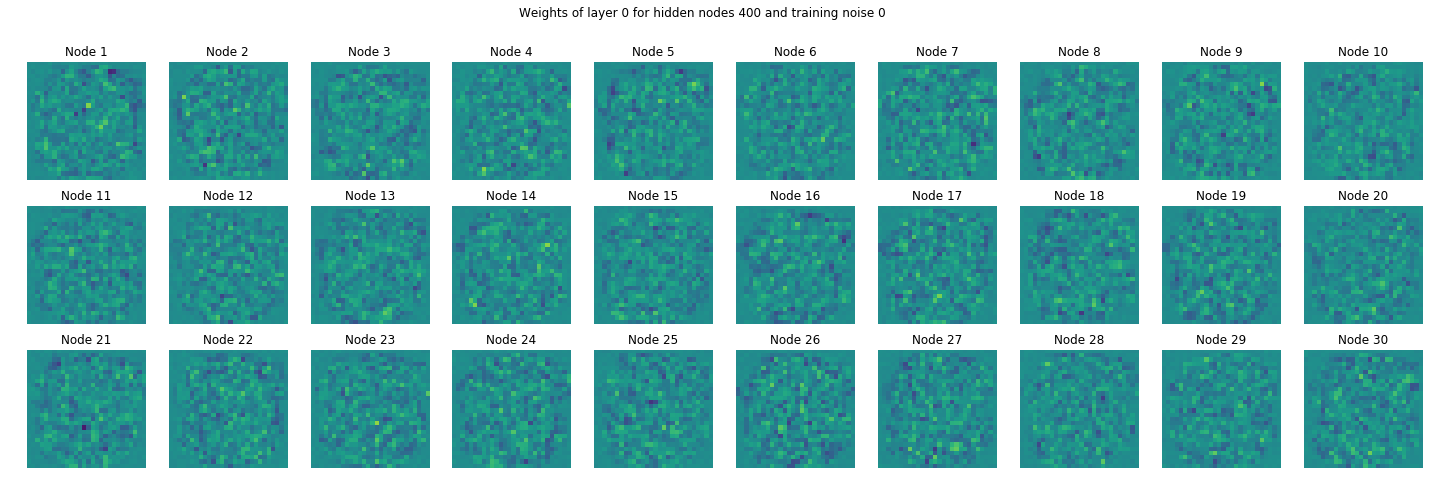

In [60]:
layer_index = 0
training_noise = 0
preview_weights_by_layer(saved_models_by_noise[training_noise],
                         layer_index,
                         limit_nodes=30,
                         title=" for hidden nodes "+str(hidden_nodes)+" and training noise "+ \
                               str(training_noise))

- 0.4 noise added to the training

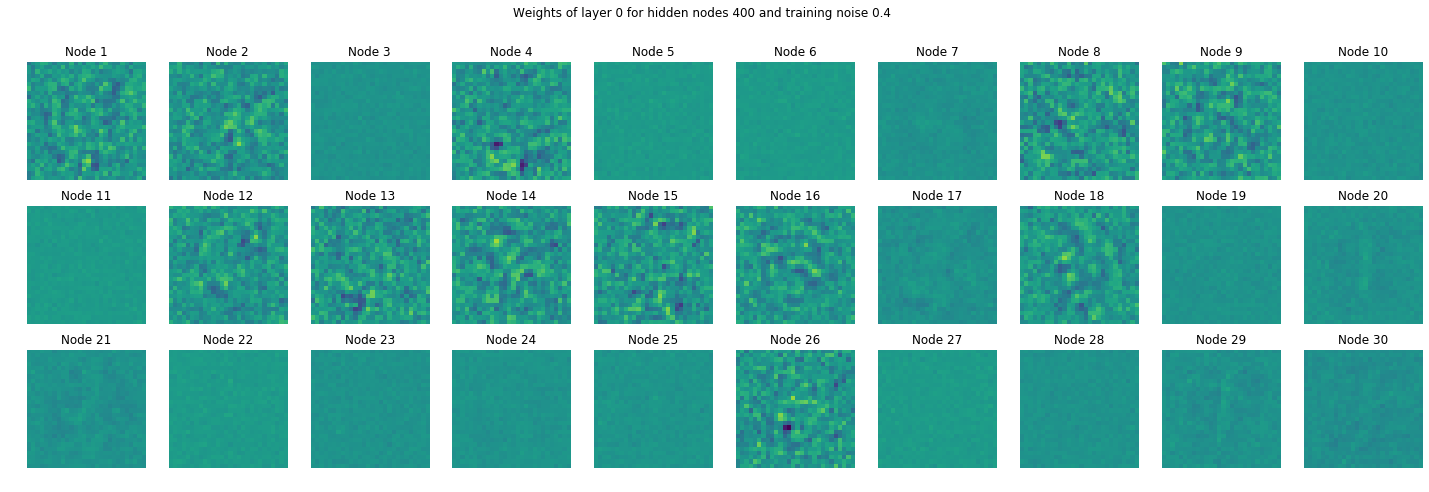

In [61]:
layer_index = 0
training_noise = 0.4
preview_weights_by_layer(saved_models_by_noise[training_noise],
                         layer_index,
                         limit_nodes=30,
                         title=" for hidden nodes "+str(hidden_nodes)+" and training noise "+ \
                               str(training_noise))

### Overcomplete representations without noise: 1000, 2000, 4000 hidden nodes

Compare lerning curves by hidden nodes.

Training: hidden_nodes 1000
Training: hidden_nodes 2000
Training: hidden_nodes 4000


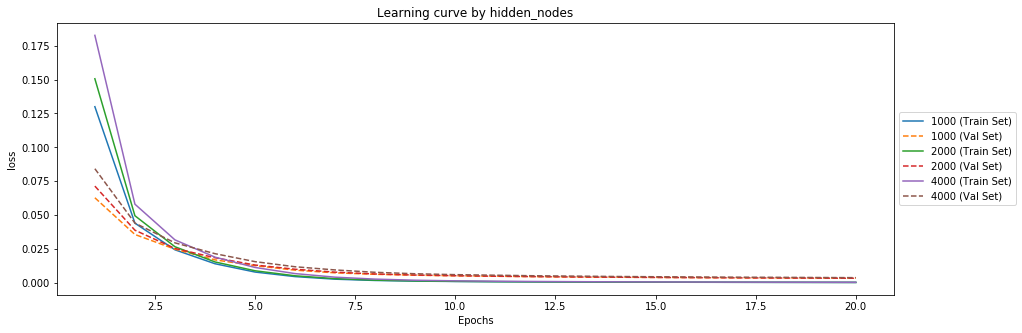

In [62]:
parameter_to_compare = 'hidden_nodes'
values_to_compare = [1000,2000,4000]
saved_models_by_hidden_nodes = compare_learning_curve(parameter_to_compare, values_to_compare,
                                                      model_arguments={'optimizer': 'Adam_amsgrad',
                                                                       'learning_rate': 0.01,
                                                                       'batch_size': 32},
                                                      train_arguments={'inputs': digits_train_split,
                                                                       'inputs_val': digits_val_split,
                                                                       'epochs': 20,
                                                                       'learning_curve': True})

Compare lerning curves by hidden layer activations functions.

Training: activation_hidden sigmoid
Training: activation_hidden relu


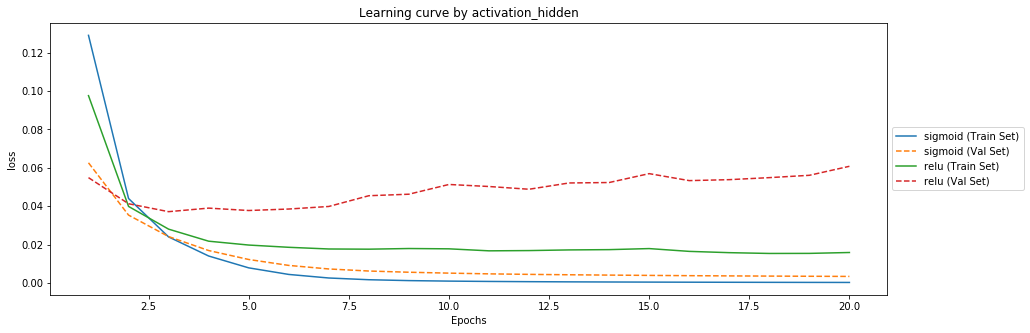

In [63]:
hidden_nodes = 1000
parameter_to_compare = 'activation_hidden'
values_to_compare = ['sigmoid','relu']
saved_models_by_reg_l1 = compare_learning_curve(parameter_to_compare, values_to_compare,
                                                model_arguments={'hidden_nodes': hidden_nodes,
                                                                 'optimizer': 'Adam_amsgrad',
                                                                 'learning_rate': 0.01,
                                                                 'batch_size': 32,
                                                                 'regularization_method': 'l1'},
                                                train_arguments={'inputs': digits_train_split,
                                                                 'inputs_val': digits_val_split,
                                                                 'epochs': 20,
                                                                 'learning_curve': True})

Compare lerning curves by regularizations L1.

Training: regularization 1e-08
Training: regularization 1e-06
Training: regularization 0.0001


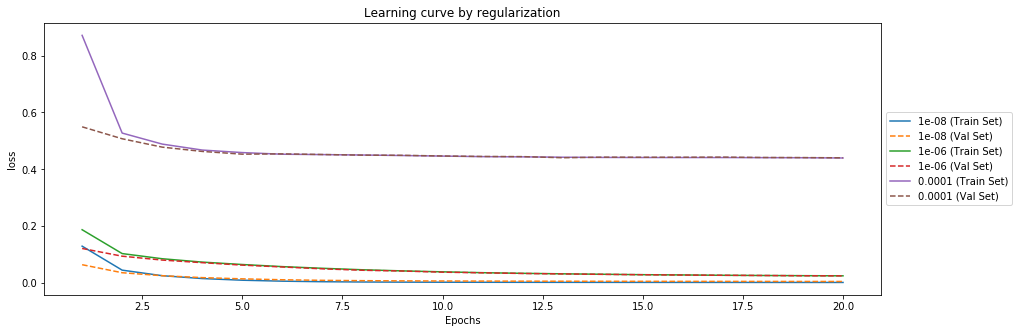

In [64]:
hidden_nodes = 1000
parameter_to_compare = 'regularization'
values_to_compare = [1e-8,1e-6,1e-4]
saved_models_by_reg_l1 = compare_learning_curve(parameter_to_compare, values_to_compare,
                                                model_arguments={'hidden_nodes': hidden_nodes,
                                                                 'optimizer': 'Adam_amsgrad',
                                                                 'learning_rate': 0.01,
                                                                 'batch_size': 32,
                                                                 'regularization_method': 'l1'},
                                                train_arguments={'inputs': digits_train_split,
                                                                 'inputs_val': digits_val_split,
                                                                 'epochs': 20,
                                                                 'learning_curve': True})

Compare lerning curves by regularizations L2.

Training: regularization 1e-08
Training: regularization 1e-06
Training: regularization 0.0001


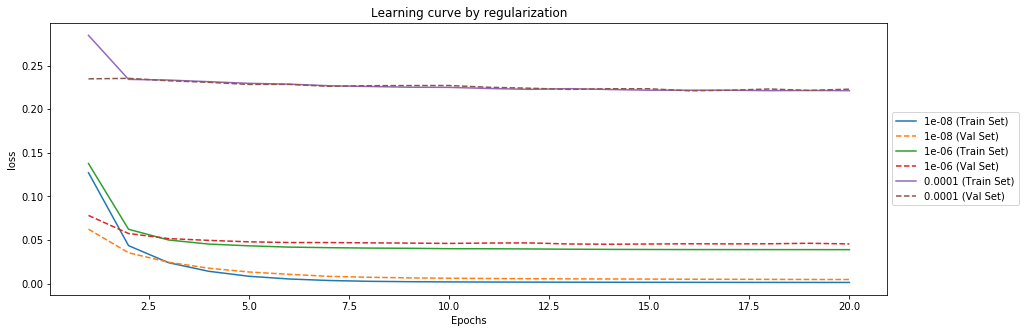

In [65]:
hidden_nodes = 1000
parameter_to_compare = 'regularization'
values_to_compare = [1e-8,1e-6,1e-4]
saved_models_by_reg_l1 = compare_learning_curve(parameter_to_compare, values_to_compare,
                                                model_arguments={'hidden_nodes': hidden_nodes,
                                                                 'optimizer': 'Adam_amsgrad',
                                                                 'learning_rate': 0.01,
                                                                 'batch_size': 32,
                                                                 'regularization_method': 'l2'},
                                                train_arguments={'inputs': digits_train_split,
                                                                 'inputs_val': digits_val_split,
                                                                 'epochs': 20,
                                                                 'learning_curve': True})

Compare sparsity of activations by regularizations L1.

- 1e-8 L1 regularization

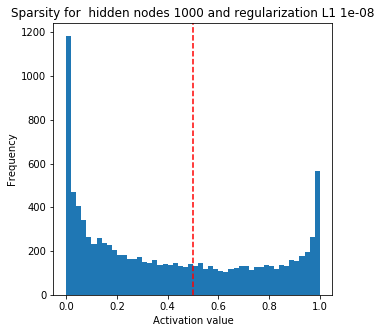

In [67]:
layer_index = 0
regularization = 1e-8
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_reg_l1[regularization],
                              layer_index,
                              inputs_to_preview,
                              title=" hidden nodes "+str(hidden_nodes)+" and regularization L1 "+ \
                                    str(regularization))

- 1e-6 L1 regularization

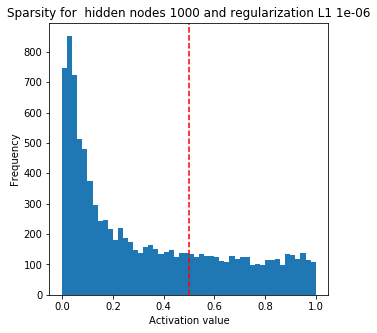

In [68]:
layer_index = 0
regularization = 1e-6
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_reg_l1[regularization],
                              layer_index,
                              inputs_to_preview,
                              title=" hidden nodes "+str(hidden_nodes)+" and regularization L1 "+ \
                                    str(regularization))

- 1e-4 L1 regularization

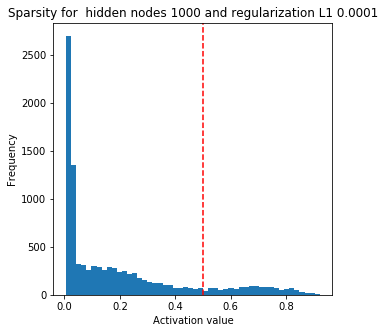

In [69]:
layer_index = 0
regularization = 1e-4
inputs_to_preview = digits_val_split[demo_indices_val_split,:]
sparsity_activations_by_layer(saved_models_by_reg_l1[regularization],
                              layer_index,
                              inputs_to_preview,
                              title=" hidden nodes "+str(hidden_nodes)+" and regularization L1 "+ \
                                    str(regularization))

Compare histogram of weights by regularization L1 values.

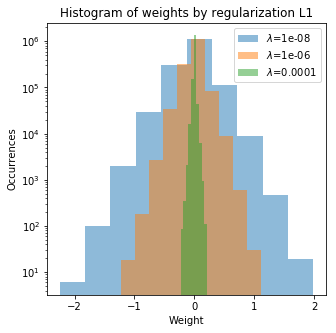

In [70]:
plt.figure(figsize=(5,5))
for regularization in [1e-8,1e-6,1e-4]:    
    model = saved_models_by_reg_l1[regularization]
    all_weights = np.concatenate([layer.get_weights()[0].flatten() for layer in model._model.layers])
    plt.hist(all_weights, alpha=0.5, label="$\lambda$={}".format(regularization), log=True)    
plt.xlabel("Weight")
plt.ylabel("Occurrences")
plt.legend()
plt.title("Histogram of weights by regularization L1")

## 3.2. Stacked autoencoders for MNIST digit classification

Convert labels to categorical representation.

In [71]:
targets_train = keras.utils.to_categorical(targets_train)
targets_test = keras.utils.to_categorical(targets_test)
targets_train_split = keras.utils.to_categorical(targets_train_split)
targets_val_split = keras.utils.to_categorical(targets_val_split)

Create a function to train a deep model with Keras and these options:
- autoencoders with/out glass shape
- output layer for classification
- greedy pretraining of autoencoder (training to predict inputs before training the output classification layer
- dropout
- batch normalization

In [72]:
def train_deep_model(# Data
                     inputs_train,
                     targets_train,
                     inputs_val,
                     targets_val,
    
                     # Architecture parameters
                     hidden_nodes,
                     glass_shape=True,
                     classify=True,
                     activation_hidden='sigmoid',
                     activation_output='softmax',
                     kernel_initializer='random_normal',
                     bias_initializer='zeros',
    
                     # Regularization parameters
                     regularization=0,
                     regularization_method='l1',
                     batch_normalization=False,
                     pre_training=True,
                     dropout_rate_pretraining=None,
    
                     # Optimization parameters           
                     optimizer='SGD_momentum',
                     momentum=0.9,
                     learning_rate=0.01,
                     epochs=10,
                     epochs_pretrain=10,
                     batch_size=64,
                     loss_pre_training='binary_crossentropy', # because MINST images have binary pixels
                     loss_classify='categorical_crossentropy',
                     metrics_classify=['acc']):

    ##################################################################################################
    # CONSTRUCT NETWORK ARCHITECTURE
    ##################################################################################################
    
    # Store index of layers for future pretraining
    encoder_layers_index = []
    if glass_shape:
        decoder_layers_index = []
    if batch_normalization:
        batch_normalization_layers_index = []
    
    # Define input layer
    num_inputs = inputs_train.shape[1]
    num_outputs = targets_train.shape[1] # one hot encoded targets (as much columns as possible labels)
    input_layer = keras.layers.Input(shape=(num_inputs,), name="input")
    
    if hidden_nodes:
        
        # Create ENCODER iterating hidden nodes (and connecting to the previous encoder layer)
        encoder = input_layer
        reg_method = {'l1': keras.regularizers.l1, 'l2': keras.regularizers.l2}[regularization_method]
        for i, hidden_nodes_this_layer in enumerate(hidden_nodes):
            encoder = keras.layers.Dense(
                units=hidden_nodes_this_layer,
                activation=activation_hidden,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=reg_method(regularization),
                name="encoder_{}".format(i+1)
            )(encoder)
            
            # Add batch normalization layer (if required)
            if batch_normalization:
                encoder = keras.layers.BatchNormalization(
                    name="batch_normalization_{}".format(i+1)
                )(encoder)
                encoder_layers_index.append(1+2*i) # input layer is the first one (index=0)
                batch_normalization_layers_index.append(2+2*i)
            else:
                encoder_layers_index.append(1+i)
        
        # Create DECODER iterating inversely hidden nodes (and connecting to the previous decoder layer)
        if glass_shape:
            decoder = encoder
            for i, hidden_nodes_this_layer in enumerate(hidden_nodes[::-1][1:]+[num_inputs]):
                decoder = keras.layers.Dense(
                    units=hidden_nodes_this_layer,
                    activation=activation_hidden,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    kernel_regularizer=reg_method(regularization),
                    name="decoder_{}".format(i+1)
                )(decoder)
                decoder_layers_index.append(1+(2 if batch_normalization else 1)*len(hidden_nodes)+i)
        
        # In case no glass shape and not clasify we need to add 1 decoder layer
        elif not classify: 
            decoder = keras.layers.Dense(
                units=num_inputs,
                activation=activation_hidden,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=reg_method(regularization),
                name="decoder_{}".format(1)
            )(encoder)
        
        # Define the ClASSIFICATION layer (connected to the encoder/decoder) and the Keras model
        if classify:
            if glass_shape:
                classifier_layer = keras.layers.Dense(
                    num_outputs,
                    activation=activation_output,
                    name="classifier"
                )(decoder)
            else:
                classifier_layer = keras.layers.Dense(
                    num_outputs,
                    activation=activation_output,
                    name="classifier"
                )(encoder)
            model = keras.models.Model(input_layer, classifier_layer)
        else:
            model = keras.models.Model(input_layer, decoder)
    
    # If no hidden layers required the model connects the input layer directly to the output layer
    elif classify:
        
        # Define the CLASSIFICATION layer (connected to the input)
        classifier_layer = keras.layers.Dense(
            num_outputs,
            activation=activation_output,
            name="classifier"
        )(input_layer)
        
        # Define the Keras model
        model = keras.models.Model(input_layer, classifier_layer)

    ##################################################################################################
    # UNSUPERVISED GREEDY PRETRAINING OF AUTOENCODER (layer by layer)
    ##################################################################################################
    
    opt = {'SGD': keras.optimizers.SGD,
           'SGD_momentum': partial(keras.optimizers.SGD, momentum=momentum),
           'SGD_momentum_nesterov': partial(keras.optimizers.SGD, momentum=momentum, nesterov=True),
           'Adagrad': keras.optimizers.Adagrad,
           'Adadelta': keras.optimizers.Adadelta,
           'RMSprop': keras.optimizers.RMSprop,
           'Adam': keras.optimizers.Adam,
           'Adamax': keras.optimizers.Adamax,
           'Nadam': keras.optimizers.Nadam,
           'Adam_amsgrad': partial(keras.optimizers.Adam, amsgrad=True)
          }[optimizer]

    if pre_training and glass_shape:
        
        # Train layer weights iterating hidden nodes (glass shape)
        inputs_train_this_layer = inputs_train.copy()
        for i, hidden_nodes_this_layer in enumerate(hidden_nodes):
            
            # Define input layer of the iteration
            num_inputs = inputs_train_this_layer.shape[1]
            input_layer = keras.layers.Input(shape=(num_inputs,))
            
            # Add Droupout regularization (if required)
            if dropout_rate_pretraining is not None:
                input_layer_distorted = keras.layers.Dropout(dropout_rate_pretraining)(input_layer)
            else:
                input_layer_distorted = input_layer
            
            # Define the hidden layer of the iteration (encoder)
            encoded = keras.layers.Dense(
                units=hidden_nodes_this_layer,
                activation=activation_hidden,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=reg_method(regularization)
            )(input_layer_distorted)
            
            # Add batch normalization layer (if required)
            if batch_normalization:
                encoded = keras.layers.BatchNormalization()(encoded)
            
            # Define the output layer of the iteration (decoder)
            decoded = keras.layers.Dense(
                units=num_inputs,
                activation=activation_hidden,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
                kernel_regularizer=reg_method(regularization)
            )(encoded)
            
            # Set up optimization and train
            autoencoder = keras.models.Model(input_layer, decoded)
            autoencoder.compile(optimizer=opt(lr=learning_rate), loss=loss_pre_training)
            autoencoder.fit(inputs_train_this_layer,
                            inputs_train_this_layer,
                            batch_size=batch_size,
                            epochs=epochs_pretrain,
                            verbose=0)
            
            # Save the encoder pretrained weights in the corresponding model layer
            index_encoder = (2 if dropout_rate_pretraining is not None else 1)
            weights_encoder = autoencoder.layers[index_encoder].get_weights()
            model.layers[encoder_layers_index[i]].set_weights(weights_encoder)
            
            # Save the encoder batch normalization pretrained weights in the corresponding model layer          
            if batch_normalization:
                weights_batch_normalization = autoencoder.layers[index_encoder+1].get_weights()
                model.layers[batch_normalization_layers_index[i]].set_weights(weights_batch_normalization)
            
            # Save the decoder pretrained weights in the corresponding model layer
            index_decoder = index_encoder+(2 if batch_normalization else 1)
            weights_decoder = autoencoder.layers[index_decoder].get_weights()
            model.layers[decoder_layers_index[-(i+1)]].set_weights(weights_decoder)
            
            # Update the input data for next layer: input -> dropout -> hidden -> batch norm -> output                
            if dropout_rate_pretraining is not None and batch_normalization:
                layer_index = 3
            elif dropout_rate_pretraining is not None or batch_normalization:
                layer_index = 2
            else:
                layer_index = 1
            get_hidden_activations = keras.backend.function([autoencoder.input],
                                                            [autoencoder.layers[layer_index].output])
            inputs_train_this_layer = get_hidden_activations([inputs_train_this_layer])[0]
    
    ##################################################################################################
    # SET UP OPTIMIZATION AND TRAIN
    ##################################################################################################
    
    if classify:
        model.compile(optimizer=opt(lr=learning_rate), loss=loss_classify, metrics=metrics_classify)        
    else:
        model.compile(optimizer=opt(lr=learning_rate), loss=loss_pre_training)
    history = model.fit(inputs_train,
                        (targets_train if classify else inputs_train),
                        validation_data=(inputs_val,(targets_val if classify else inputs_val)),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)
    
    # Store errors
    errors = {'epochs': range(1, epochs+1), 'loss_train': history.history['loss']}
    if classify:
        for metric in metrics_classify:
            errors[metric+'_train'] = history.history[metric]
    if inputs_val is not None:
        errors['loss_val'] = history.history['val_loss']
        if classify:
            for metric in metrics_classify:
                errors[metric+'_val'] = history.history['val_'+metric]
    
    return (model, errors)

Define a function to compare deep models learning curves by metrics.

In [73]:
def compare_deep_models(parameter_to_compare, values_to_compare, labels_values_to_compare=None,
                        metrics=['loss','acc'],
                        arguments={'hidden_nodes': [300,200,100],
                                   'inputs_train': digits_train_split,
                                   'targets_train': targets_train_split,
                                   'inputs_val': digits_val_split,
                                   'targets_val': targets_val_split}):
    
    # Define one plot (column) for each metric
    _, axes = plt.subplots(1, len(metrics), figsize=(15,7.5))
    
    # Train with each value to compare, plot its learning curve and save its model
    cmap = plt.get_cmap('tab10')
    if labels_values_to_compare is None:
        labels_values_to_compare = values_to_compare
    models = {}
    for i, (value,label) in enumerate(zip(values_to_compare, labels_values_to_compare)):
        
        # Train the model
        print("TRAINING "+parameter_to_compare+' '+str(value))
        arguments[parameter_to_compare] = value
        model, errors = train_deep_model(**arguments)
        models[i] = model
        
        # Plot learning curves by metrics
        for metric, ax in zip(metrics, axes):
            ax.plot(errors['epochs'], errors[metric+'_train'], label=str(label)+' (Train Set)', c=cmap(i))
            ax.plot(errors['epochs'], errors[metric+'_val'], label=str(label)+' (Val Set)', linestyle='--',
                    c=cmap(i))
    
    # Edit the plots
    for metric, ax in zip(metrics, axes):
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()
    
    return models

Comparing deep models as classifiers with:
- Pretraining: Yes
- Glass shape architecture: Yes
- Regularization L1: 0
- Batch normalization: No
- Dropout rate in pretraining: 0

TRAINING hidden_nodes []
TRAINING hidden_nodes [300]
TRAINING hidden_nodes [300, 200]
TRAINING hidden_nodes [300, 200, 100]


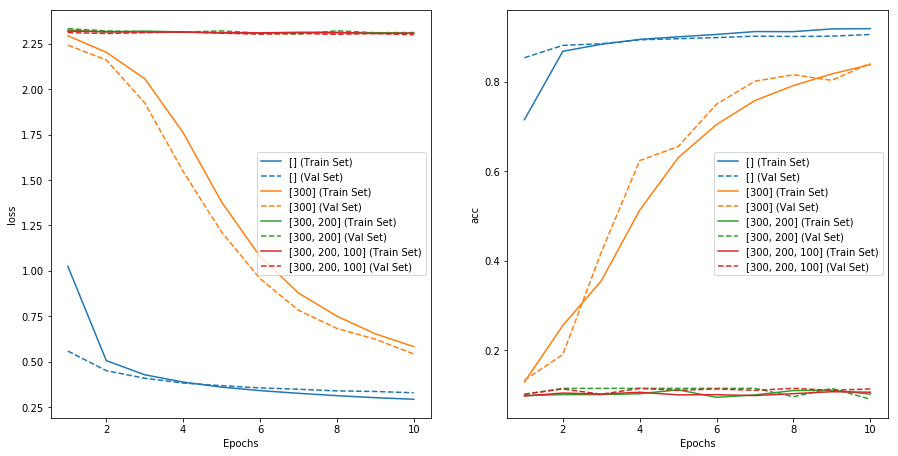

In [75]:
models = compare_deep_models('hidden_nodes', [[],[300],[300,200],[300,200,100]])

Comparing architectures of deep models as classifiers with:
- Pretraining: No
- Glass shape architecture: Yes
- Regularization L1: 0
- Batch normalization: No
- Dropout rate in pretraining: 0

TRAINING hidden_nodes []
TRAINING hidden_nodes [300]
TRAINING hidden_nodes [300, 200]
TRAINING hidden_nodes [300, 200, 100]


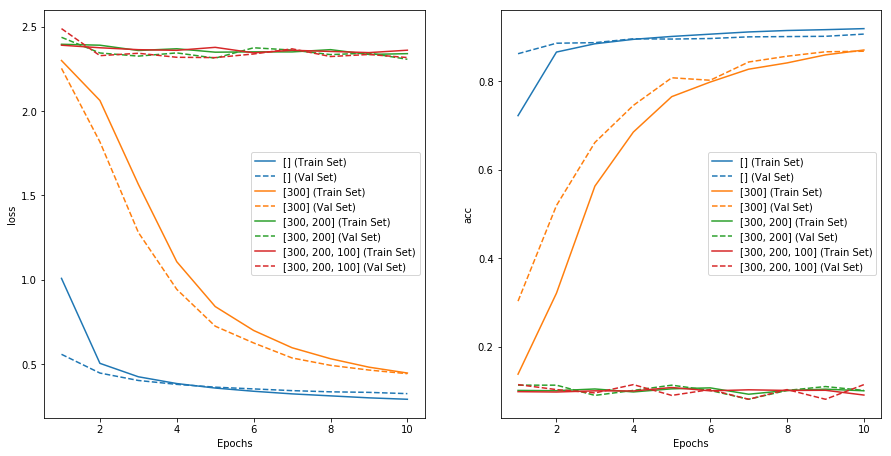

In [76]:
compare_deep_models('hidden_nodes', [[],[300],[300,200],[300,200,100]],
                    arguments={'inputs_train': digits_train_split,
                               'targets_train': targets_train_split,
                               'inputs_val': digits_val_split,
                               'targets_val': targets_val_split,
                               'pre_training': False})

Comparing deep models as classifiers with:
- Pretraining: Yes
- Glass shape architecture: Yes
- Regularization L1: 0
- Batch normalization: Yes
- Dropout rate in pretraining: 0

TRAINING hidden_nodes []
TRAINING hidden_nodes [300]
TRAINING hidden_nodes [300, 200]
TRAINING hidden_nodes [300, 200, 100]


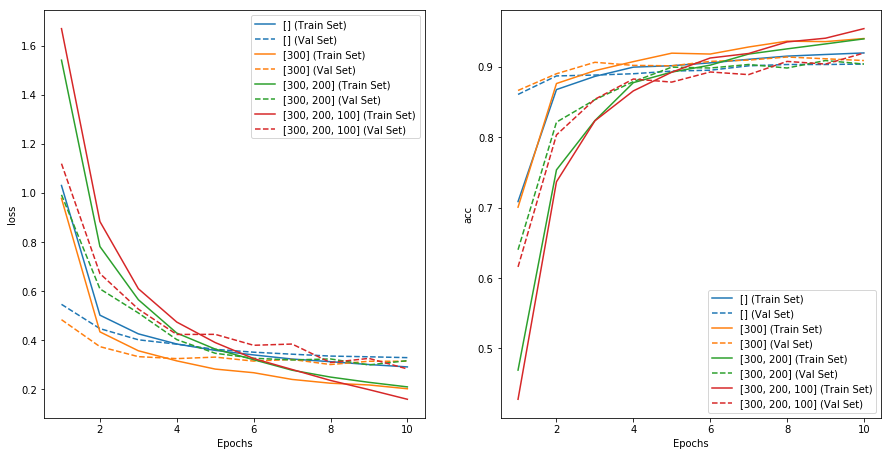

In [78]:
models = compare_deep_models('hidden_nodes', [[],[300],[300,200],[300,200,100]],
                             arguments={'inputs_train': digits_train_split,
                                        'targets_train': targets_train_split,
                                        'inputs_val': digits_val_split,
                                        'targets_val': targets_val_split,
                                        'batch_normalization': True})

Examine the summary of the last deep model.

In [79]:
models[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
encoder_2 (Dense)            (None, 200)               60200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
encoder_3 (Dense)            (None, 100)               20100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
__________

Comparing deep models as Autoencoders with:
- Pre training: Yes
- Glass shape archiecture: Yes
- Regularization L1: 0
- Batch normalization: Yes
- Dropout rate in pre training: 0

TRAINING hidden_nodes [300]
TRAINING hidden_nodes [300, 200]
TRAINING hidden_nodes [300, 200, 100]


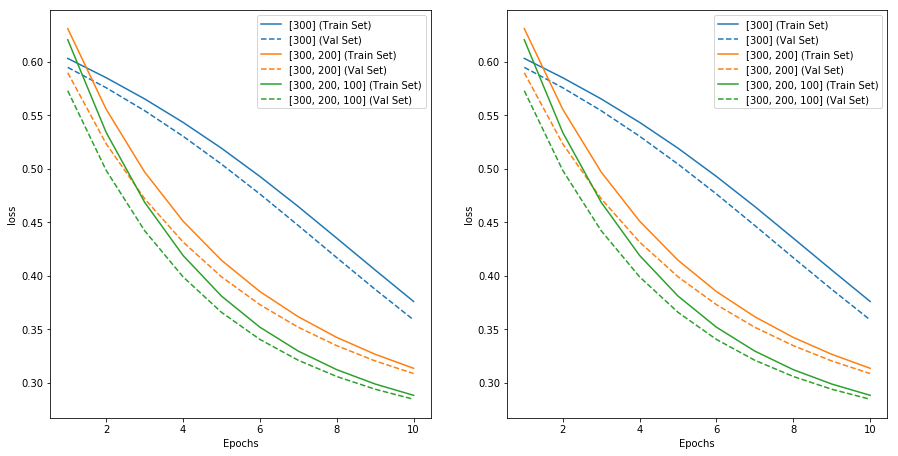

In [80]:
compare_deep_models('hidden_nodes', [[300],[300,200],[300,200,100]],
                    metrics=['loss','loss'],
                    arguments={'inputs_train': digits_train_split,
                               'targets_train': targets_train_split,
                               'inputs_val': digits_val_split,
                               'targets_val': targets_val_split,
                               'batch_normalization': True,
                               'classify': False})